In [6]:
import numpy as np
import torch
from IPython.display import Audio
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import random
from model import GCC
from scipy.optimize import minimize

# for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

ImportError: cannot import name 'GCC' from 'model' (d:\multi_source_localization\dereverb\dereverberation\model.py)

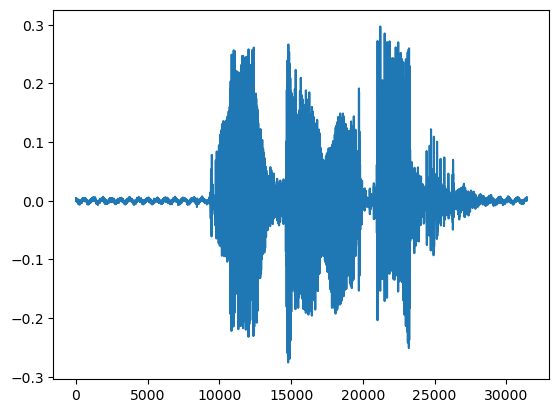

In [7]:
import librosa
import numpy as np
from matplotlib import pyplot as plt

filename = "D:/datas/librispeech/LibriSpeech/train-clean-100/19/198/19-198-0000.flac"
signal, fs = librosa.load(filename, sr = 16000)
signal = np.array(signal)

plt.plot(signal)
                          
# listen to the speech signal
Audio(filename)

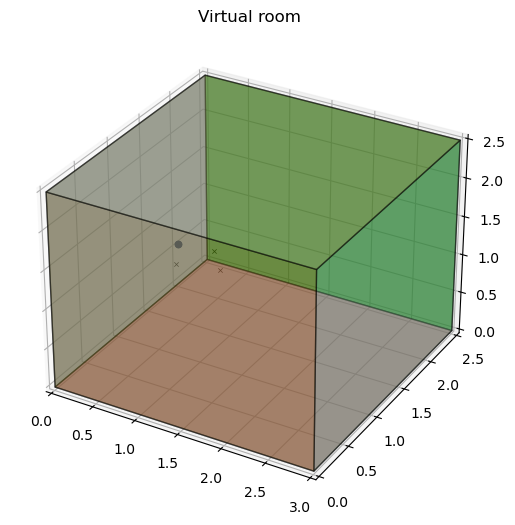

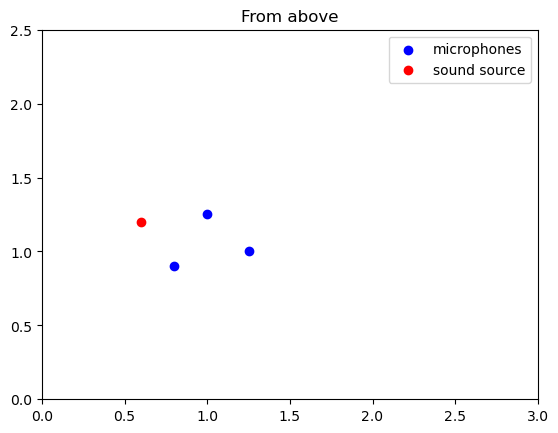

The true TDOAs are [14.904648298093212, 12.919446671572926, -1.9852016265202852]


In [8]:
room_dim= [3.0, 2.5, 2.5]
t60 = 0.6 #seconds
snr = 10 # dB

# Microphone locations
mic_locs = np.array([[1.25, 1.0, 1.25], [0.80, 0.90, 1.25], [1.0, 1.25, 1.25]]).T

# Sound source position at the same hight
source_loc = np.array([0.60, 1.20, 1.25])

# Create the virtual room
e_absorption, max_order = pra.inverse_sabine(t60, room_dim)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(
    e_absorption), max_order=max_order)

c = room.c #speed of sound

room.add_source(source_loc, signal=signal)
room.add_microphone(mic_locs)

fig, ax = room.plot()
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
ax.set_zlim([0, room_dim[2]])
plt.title('Virtual room')
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(mic_locs[0], mic_locs[1], c='b', label='microphones')
ax.scatter(source_loc[0], source_loc[1], c='r', label='sound source')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.title('From above')
plt.legend()
plt.show()

# Calculate the true TDOA 
delays = []
for pairs in [[0, 1], [0, 2], [1, 2]]:
    d = np.sqrt(np.sum((mic_locs[:, pairs[0]] - source_loc)**2)) - np.sqrt(np.sum((mic_locs[:, pairs[1]] - source_loc)**2))
    delays.append(d * fs / c)

print("The true TDOAs are " + str(delays))

torch.Size([3, 10000])


Text(0.5, 1.0, 'Signal received at mic 0')

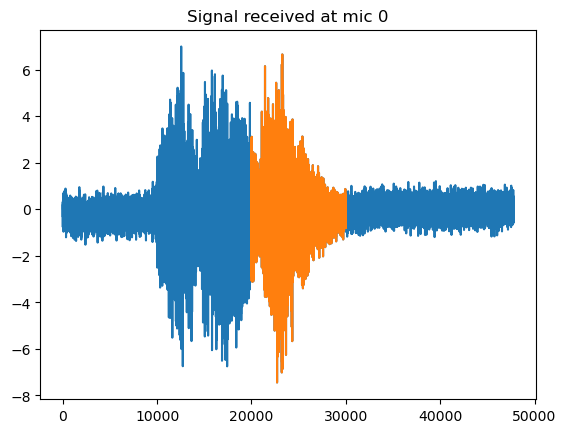

In [45]:
room.simulate(snr=snr)

y = room.mic_array.signals
plt.plot(y[0])

# Pick a 2048 samples long snippet
sig_len = 10000
start_idx = 20000
end_idx = start_idx + sig_len

x = torch.Tensor(y[:, start_idx:end_idx])
print(x.shape)
plt.plot(range(start_idx,end_idx), x[0].squeeze())
plt.title("Signal received at mic 0")

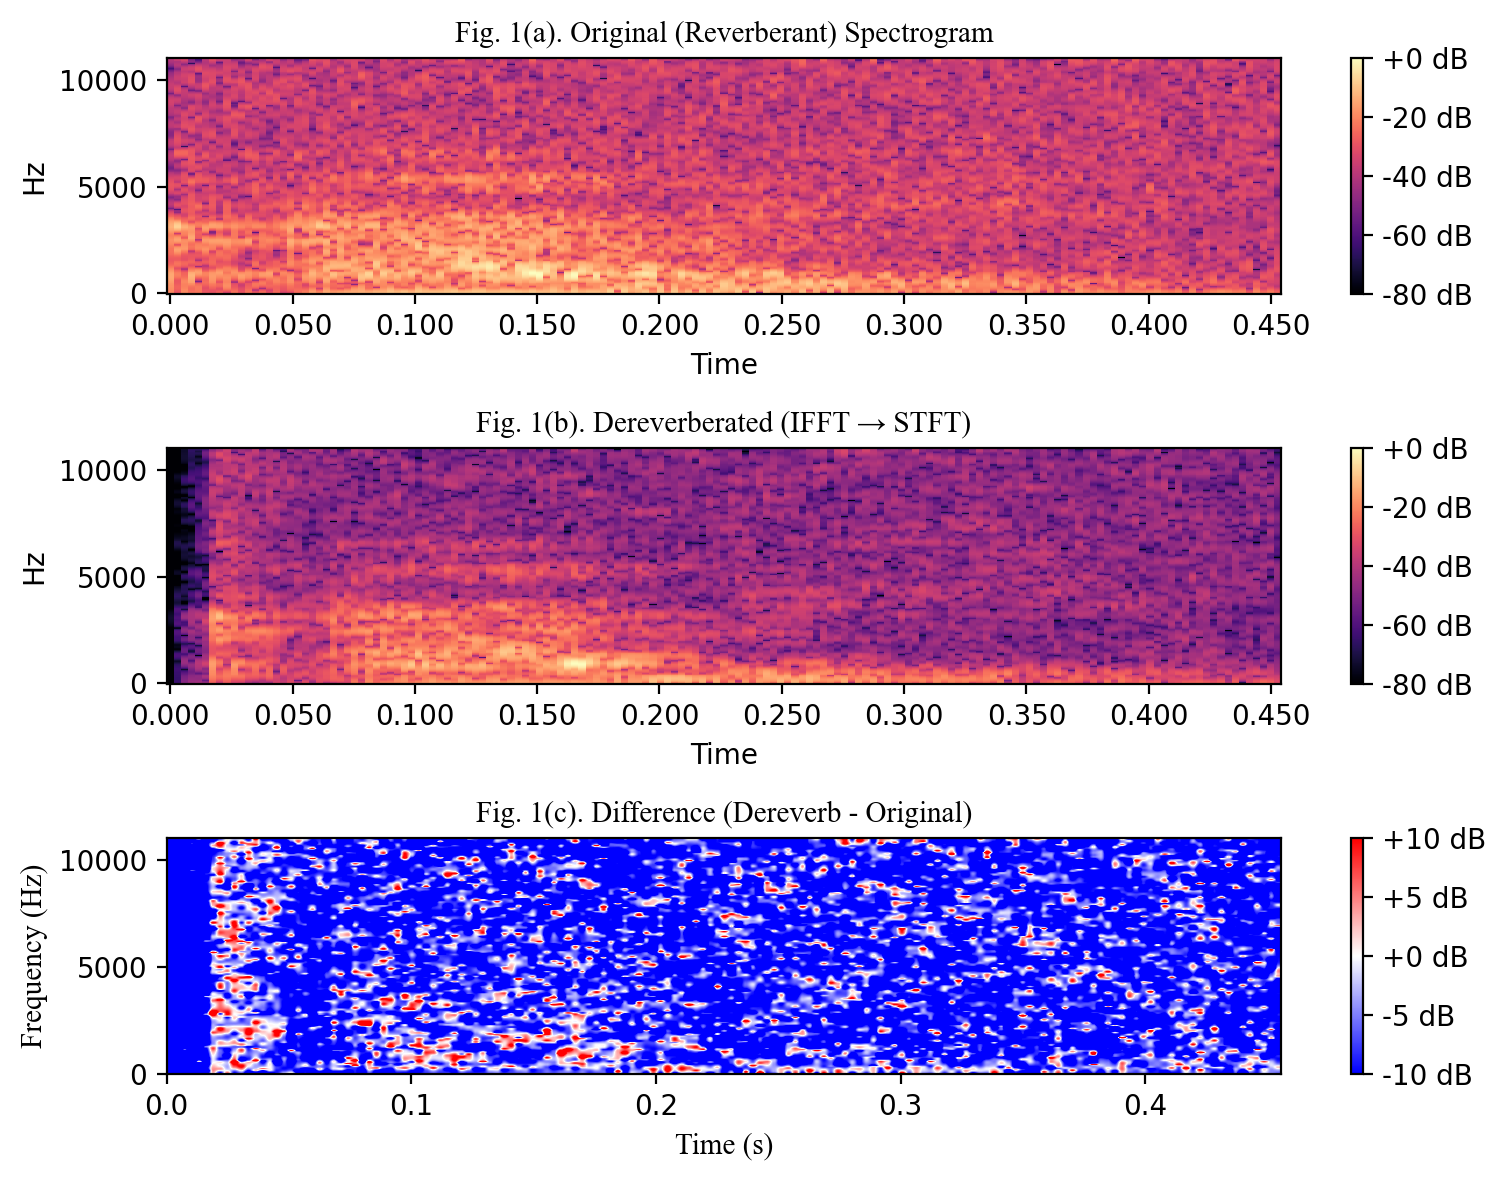

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import librosa
import librosa.display
import cfg_dereverb as cfgs
import filterbank
import lib
import estimator
from cdr_dereverb import cdr_robust

# 1. 입력 설정 (x: shape [2, T])
x1 = x[0].unsqueeze(0)  # [1, T]
x2 = x[1].unsqueeze(0)
sr = cfgs.fs  # 보통 16000

# 2. dereverberation 수행
enhanced_mic1_spec, _ = cdr_robust(x1, x2)

# 3. 시간 도메인으로 복원
p = torch.hann_window(512, periodic=True).to(x1.device)
enhanced_wave = filterbank.DFTSynRealEntireSignal(enhanced_mic1_spec[0], cfgs.K, cfgs.N, p)
enhanced_wave = enhanced_wave.cpu().numpy()
original_wave = x1[0].cpu().numpy()

# 4. STFT → log 스펙트로그램 계산
def compute_log_stft(y, sr, n_fft=512, hop_length=256, win_length=512):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')
    return librosa.amplitude_to_db(np.abs(S), ref=np.max)

S_orig_db = compute_log_stft(original_wave, sr, cfgs.K, cfgs.N//2, cfgs.N)
S_dereverb_db = compute_log_stft(enhanced_wave, sr, cfgs.K, cfgs.N//2, cfgs.N)
S_diff_db = S_dereverb_db - S_orig_db

fig, axs = plt.subplots(3, 1, figsize=(8,6), dpi=200)

# 그림 1(a): 원본
img1 = librosa.display.specshow(S_orig_db, sr=sr, hop_length=cfgs.N//2, x_axis='time', y_axis='linear', ax=axs[0])
axs[0].set_title("Fig. 1(a). Original (Reverberant) Spectrogram", fontsize=10.5, fontname='Times New Roman')
fig.colorbar(img1, ax=axs[0], format="%+2.0f dB")

# 그림 1(b): Dereverberated
img2 = librosa.display.specshow(S_dereverb_db, sr=sr, hop_length=cfgs.N//2, x_axis='time', y_axis='linear', ax=axs[1])
axs[1].set_title("Fig. 1(b). Dereverberated Spectrogram", fontsize=10.5, fontname='Times New Roman')
fig.colorbar(img2, ax=axs[1], format="%+2.0f dB")

# 그림 1(c): Difference
extent = [0, S_diff_db.shape[1] * cfgs.N//2 / sr, 0, sr / 2]
img3 = axs[2].imshow(S_diff_db, aspect='auto', origin='lower', cmap='bwr', vmin=-10, vmax=10, extent=extent)
axs[2].set_title("Fig. 1(c). Difference (Dereverb - Original)", fontsize=10.5, fontname='Times New Roman')
axs[2].set_ylabel("Frequency (Hz)", fontsize=10.5, fontname='Times New Roman')
axs[2].set_xlabel("Time (s)", fontsize=10.5, fontname='Times New Roman')
fig.colorbar(img3, ax=axs[2], format="%+2.0f dB")

# 전체 그림 여백 조정
plt.tight_layout()

# 그림 파일로 저장 (논문 삽입용)
plt.savefig("figure1_spectrograms.png", dpi=200, bbox_inches='tight')

# 화면 출력 (필요 시 제거 가능)
plt.show()
